In [1]:
!pip install -q MERF shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 8.4 MB/s eta 0:00:00


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from math import sqrt

from merf import MERF
import shap

from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
RETRAIN_MODEL = False

Prep Data

In [4]:
path = '/content/drive/My Drive/Colab Notebooks/job_satisfaction_project'

In [5]:
data = pd.read_csv(f"{path}/full_prepped_data.csv")

In [ ]:
# only full time positions
data = data.loc[data['hours_worked_week'] >= 35]

# convert to binary
data['male'] = np.where(data['gender'] == 'male', 1, 0)
data.drop(columns='male', inplace=True)

data['urban'] = np.where(data['urban_rural'] == 'urban', 1, 0)
data.drop(columns='urban_rural', inplace=True)

data['union'] = np.where(data['union'] == 'union', 1, 0)

# drop unused features
data.drop(columns=['industry', 'full_time', 'hours_worked_week', 'hours_worked_week_centered'], inplace=True)

In [7]:
# create interaction features
data.loc[:, 'pay_age'] = data['hourly_pay_centered'] * data['avg_age_per_job_centered']
data.loc[:, 'pay_tenure'] = data['hourly_pay_centered'] * data['tenure_centered']

In [8]:
features = [c for c in data.columns if c not in ['id', 'job_satisfaction', 'year']]
clusters = data['id']
X = pd.get_dummies(data[features])
Z = np.ones((len(X), 1))
y = data['job_satisfaction'].values

MERF

In [ ]:
if RETRAIN_MODEL:
  print("Training model...")
  mrf = MERF(max_iterations=5)
  mrf.fit(X, Z, clusters, y)
  pickle.dump(mrf, open(f'{path}/merf.sav', 'wb'))
  print("Model trained and saved.")
else:
  print("Loading model...")
  mrf = pickle.load(open(f'{path}/merf.sav', 'rb'))
  print("Model loaded.")

In [10]:
# evaluate on the train set
y_pred = mrf.predict(X, Z, clusters)
print("RMSE:", sqrt(mean_squared_error(y, y_pred)))
print("R-squared:", r2_score(y, y_pred))

RMSE: 0.2359769990936418
R-squared: 0.9010068526421648


SHAP

In [10]:
expl = shap.TreeExplainer(mrf.trained_fe_model, feature_perturbation='tree_path_dependent')

In [12]:
#for idx, chunk in enumerate(np.array_split(X, 100)):
#    chunk.to_csv(f'{path}/shap/x_{idx}.csv', index=False)

In [ ]:
for i, f in enumerate(os.listdir(f'{path}/shap')):
  if os.path.isfile(f'{path}/shap/shap_values_{i}.npy'):
    print("SHAP calculation done for ", f)
    print("Continuing.")
    continue
  print("Running SHAP calculation for ", f)
  X_sample = pd.read_csv(f"{path}/shap/{f}")
  shap_values = expl.shap_values(X_sample, check_additivity=False)
  np.save(f'{path}/shap/shap_values_{i}.npy', shap_values)
  print(f"SHAP values for chunk {i} saved.")
  del(X_sample)
  del(shap_values)

SHAP calculation done for  x_0.csv
Continuing.
SHAP calculation done for  x_1.csv
Continuing.
SHAP calculation done for  x_2.csv
Continuing.
SHAP calculation done for  x_3.csv
Continuing.
SHAP calculation done for  x_4.csv
Continuing.
SHAP calculation done for  x_5.csv
Continuing.
Running SHAP calculation for  x_6.csv
SHAP values for chunk 6 saved.
Running SHAP calculation for  x_7.csv
SHAP values for chunk 7 saved.
Running SHAP calculation for  x_8.csv
SHAP values for chunk 8 saved.
Running SHAP calculation for  x_9.csv
SHAP values for chunk 9 saved.
Running SHAP calculation for  x_10.csv


In [15]:
X = pd.DataFrame()

for i in range(0, 10):
  new = pd.read_csv(f"{path}/shap/x_{i}.csv")
  X = pd.concat([X, new])

In [17]:
X.shape

(11630, 27)

In [23]:
shap_values = np.load(f'{path}/shap/shap_values_0.npy')

for i in range(1, 10):
  new = np.load(f'{path}/shap/shap_values_{i}.npy')
  shap_values = np.concatenate([shap_values, new])

In [25]:
len(shap_values)

11630

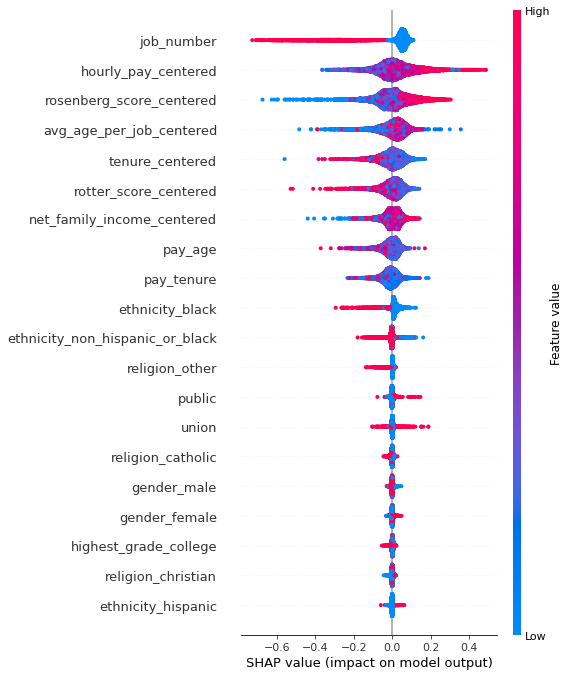

In [27]:
shap.summary_plot(shap_values, X)

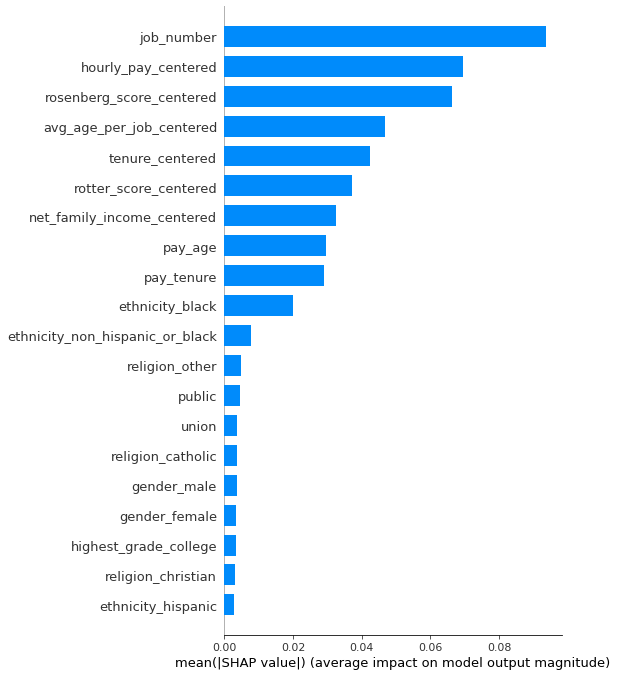

In [28]:
# feature importance
shap.summary_plot(shap_values, X, plot_type="bar")

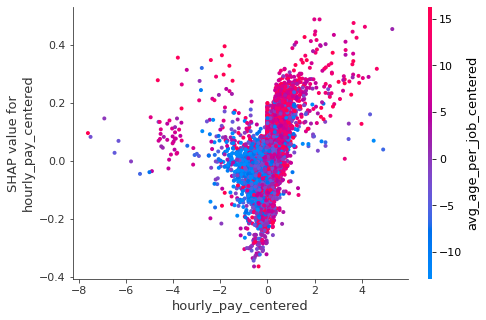

In [29]:
shap.dependence_plot("hourly_pay_centered", shap_values, X, interaction_index="avg_age_per_job_centered")

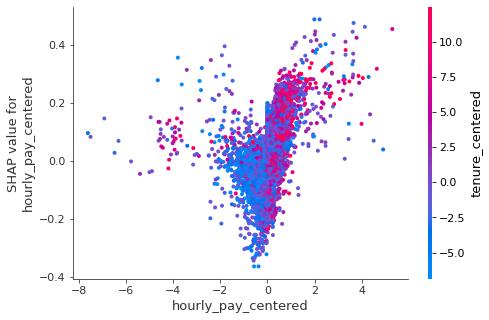

In [30]:
shap.dependence_plot("hourly_pay_centered", shap_values, X, interaction_index="tenure_centered")

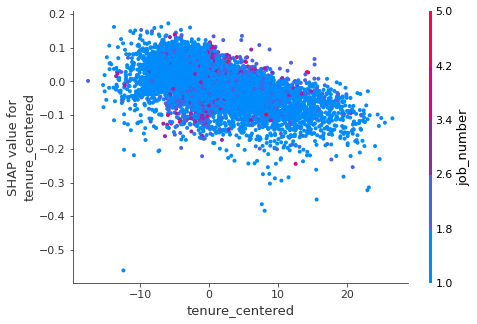

In [31]:
shap.dependence_plot("tenure_centered", shap_values, X)

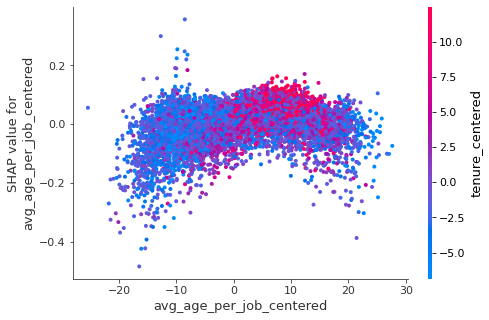

In [32]:
shap.dependence_plot("avg_age_per_job_centered", shap_values, X)

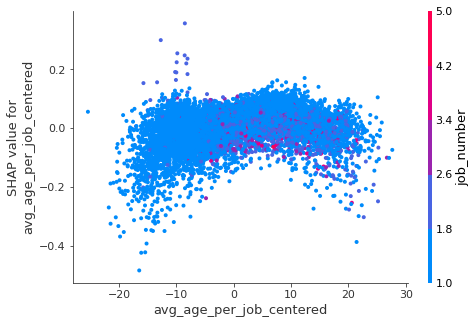

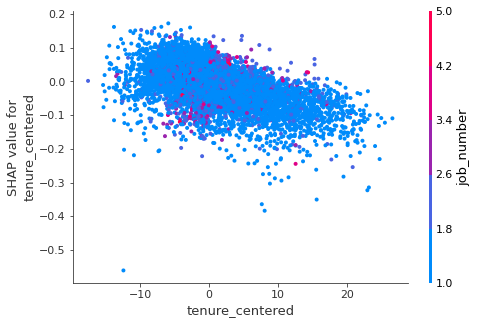

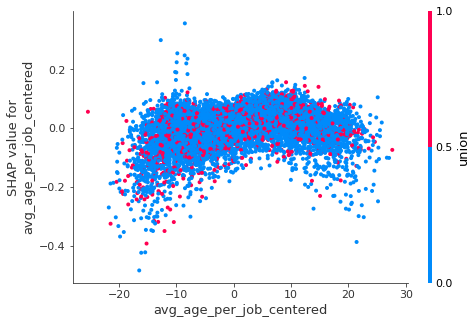

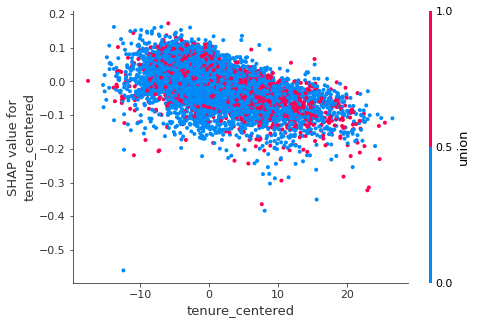

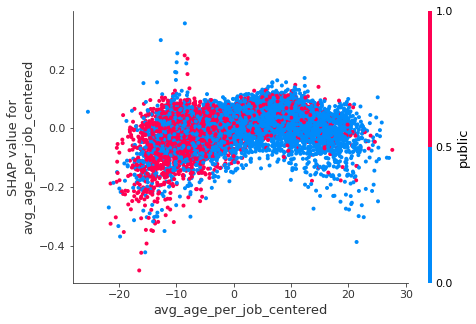

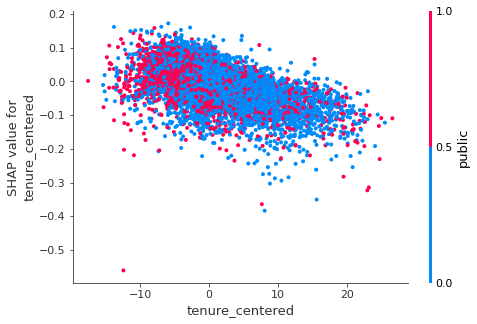

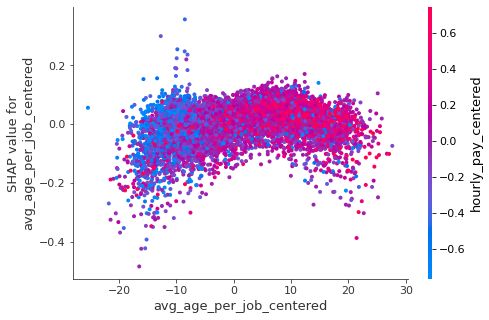

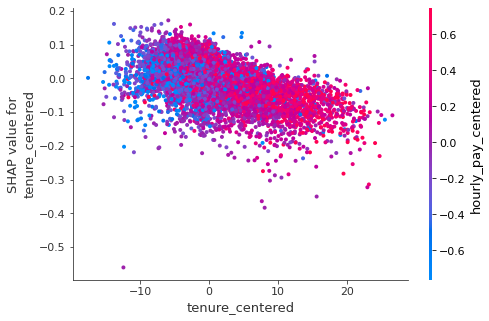

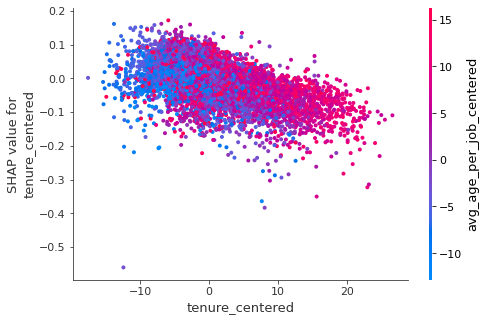

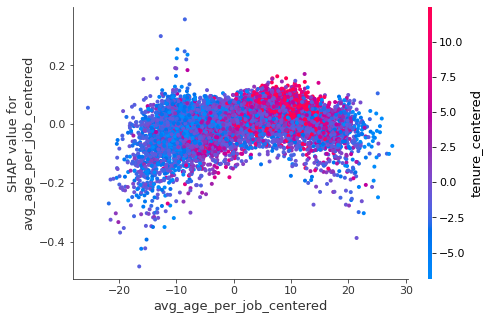

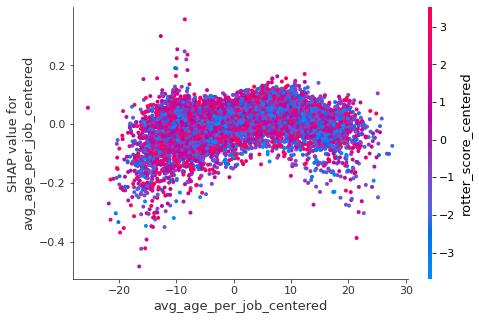

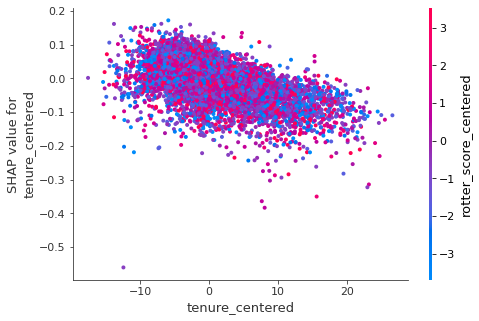

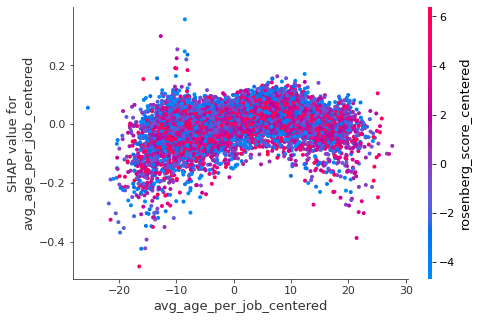

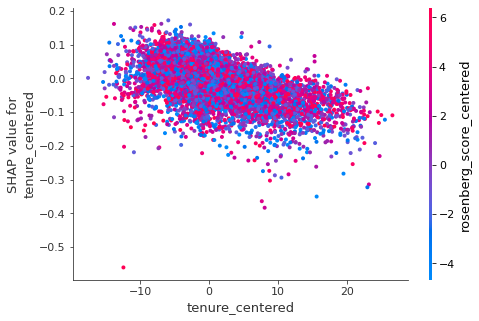

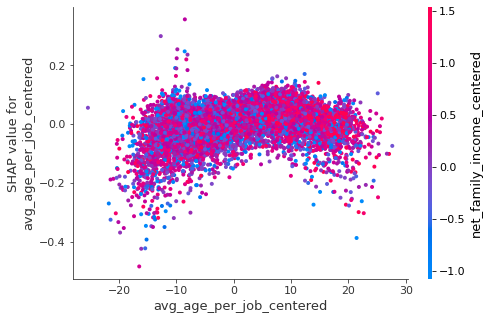

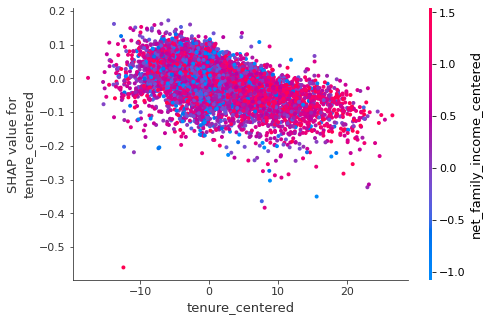

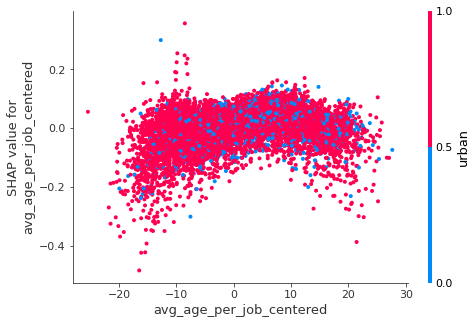

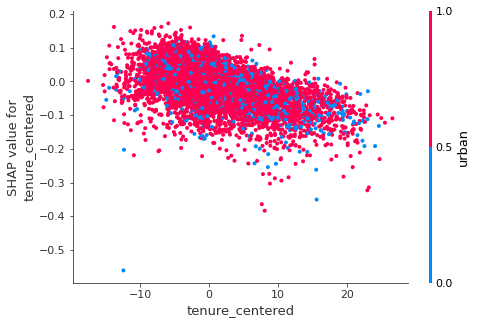

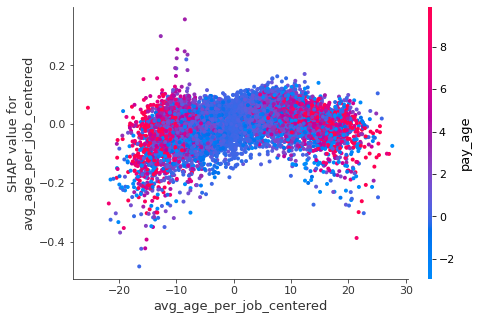

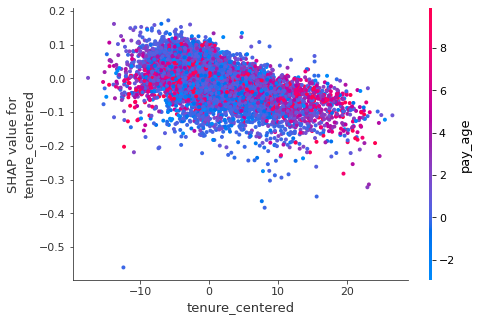

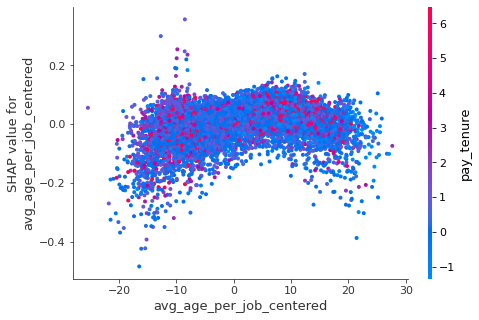

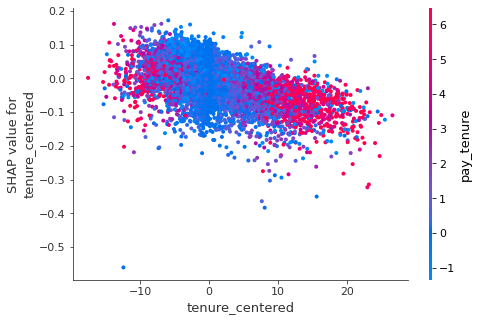

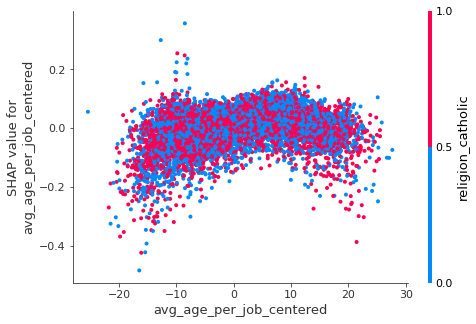

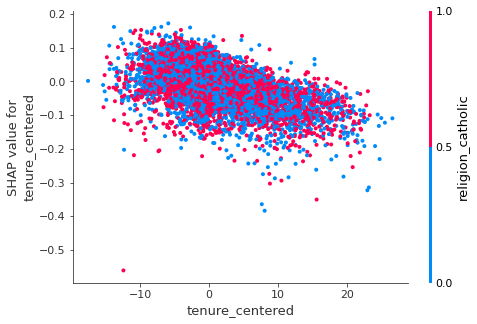

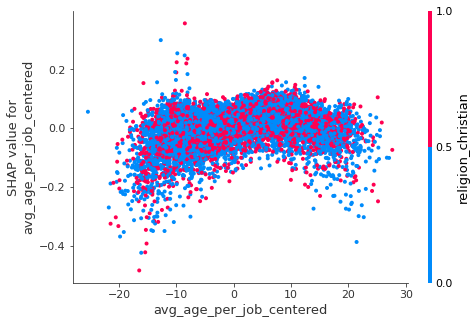

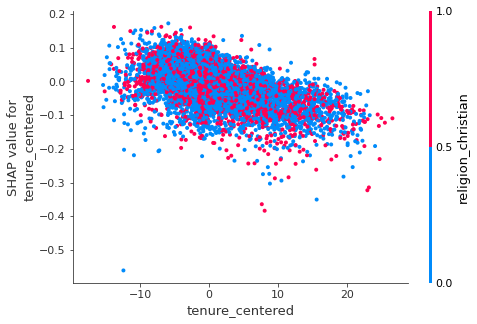

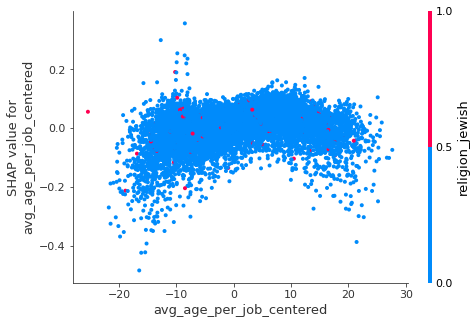

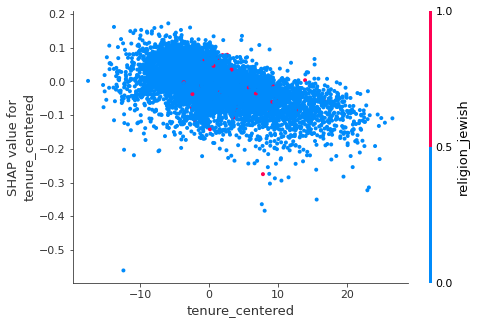

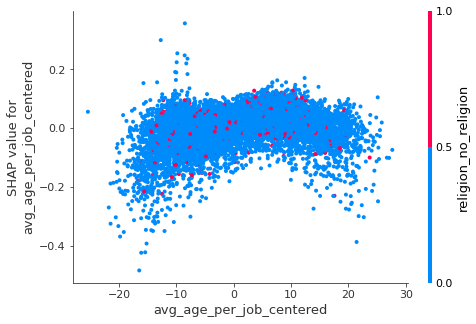

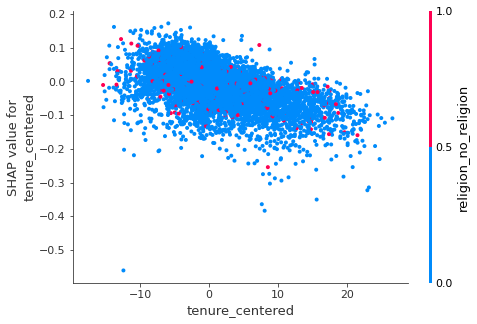

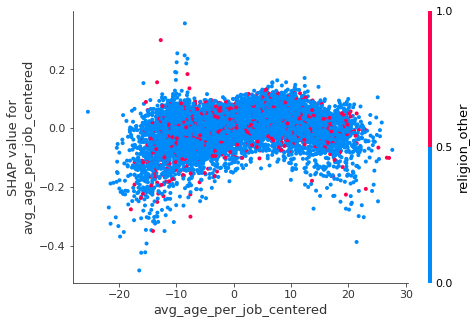

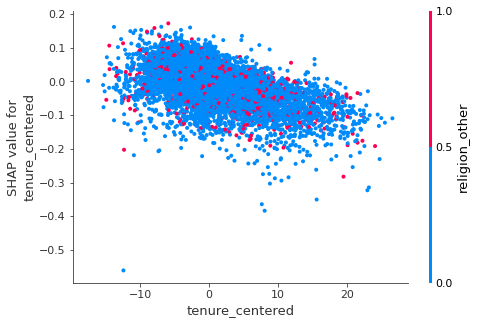

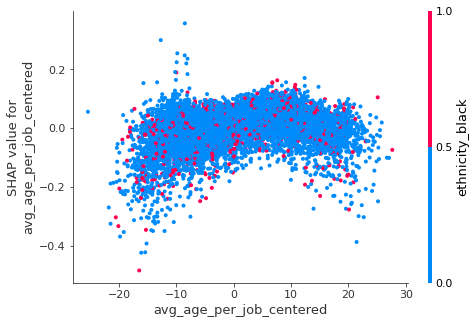

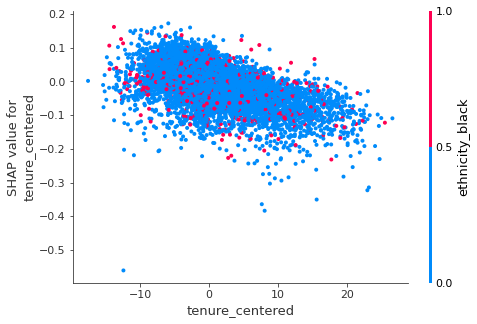

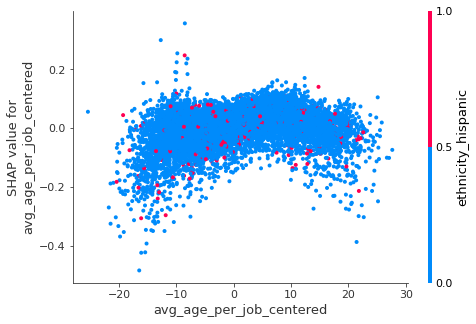

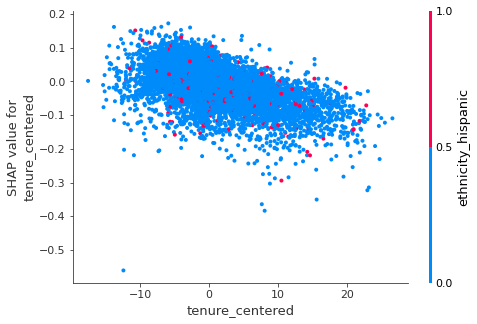

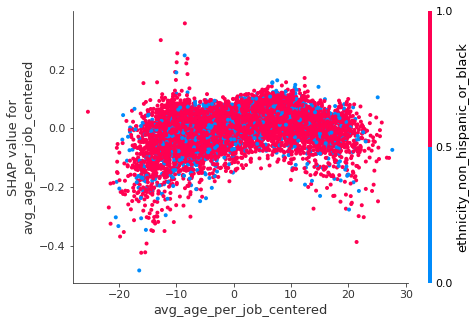

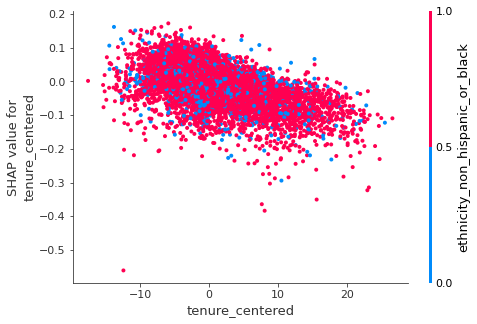

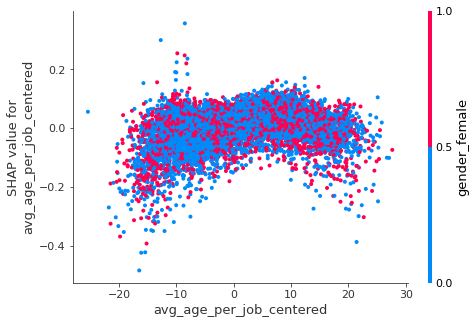

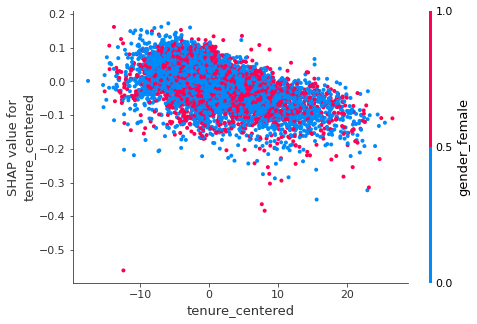

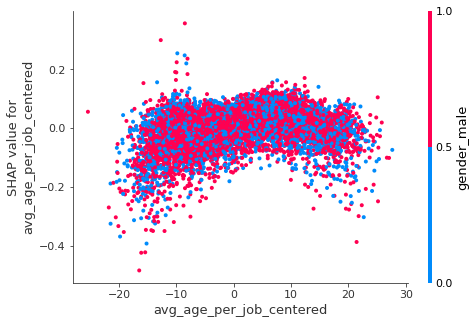

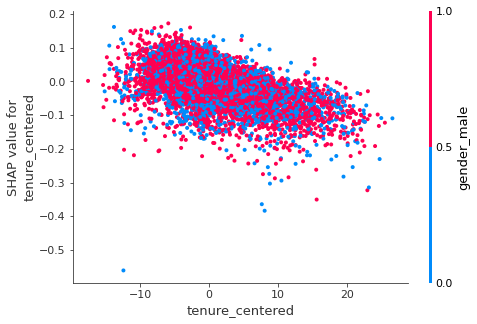

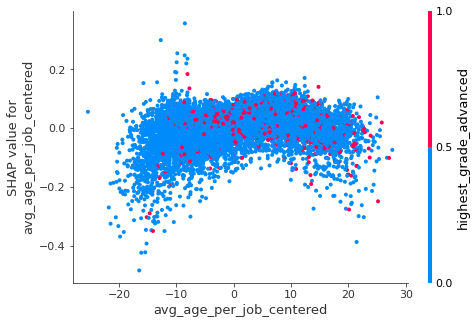

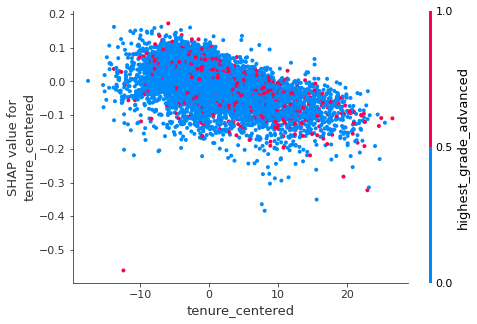

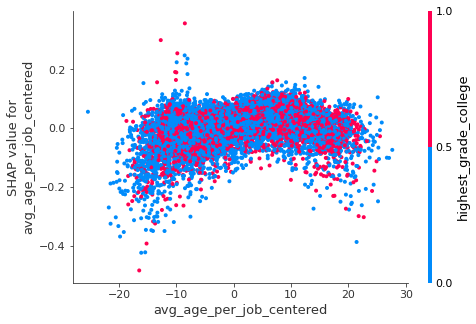

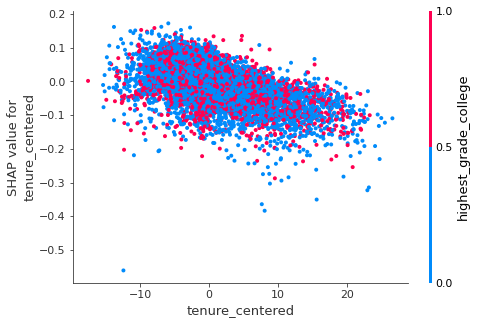

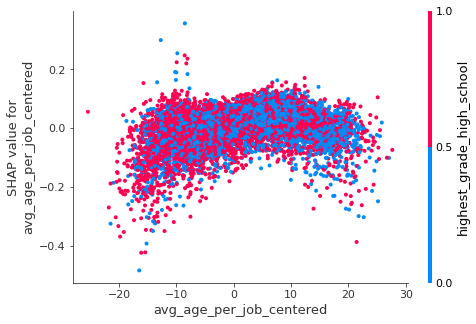

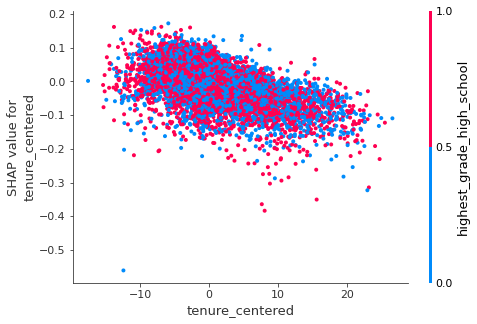

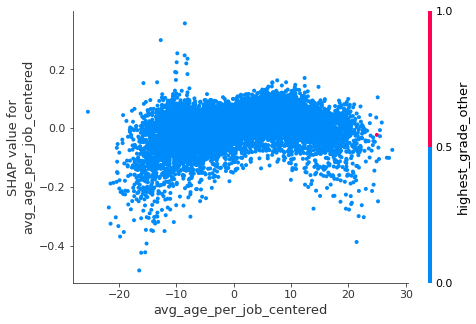

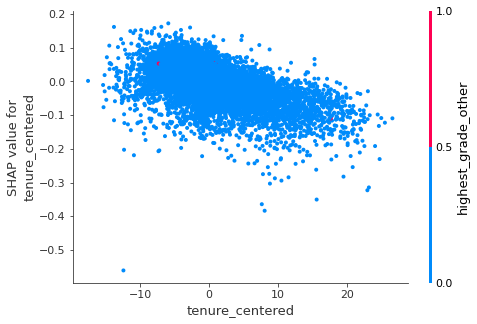

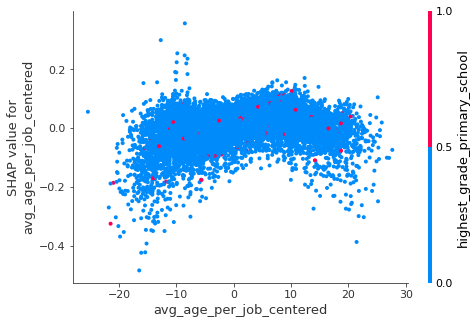

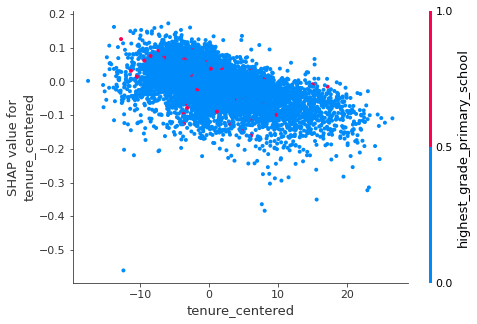

In [34]:
for f in X.columns:
  for v in ['avg_age_per_job_centered', 'tenure_centered']:
    if f != v:
      shap.dependence_plot(v, shap_values, X, interaction_index=f)

In [35]:
random_respondents = X.reset_index().sample(10)

In [36]:
shap.initjs()

# explainer.expected_value = mean job satisfaction
# shap_values for each feature of each row of the data

for i in random_respondents.index.to_list():
    display(shap.force_plot(expl.expected_value, shap_values[i], X[i:i+1]))